Install ultralytics for YOLOv8

In [ ]:
import os
import pandas as pd
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import yaml
import torch
from tqdm.auto import tqdm
import shutil

In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.1.8 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 27.1/78.2 GB disk)


In [ ]:
from ultralytics import YOLO

### Use pretrained model to test our image

In [ ]:
model = YOLO('yolov8s.pt') # pretrained model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
img = '/content/car_data/testing_images/vid_5_26760.jpg'

Image data type: uint8


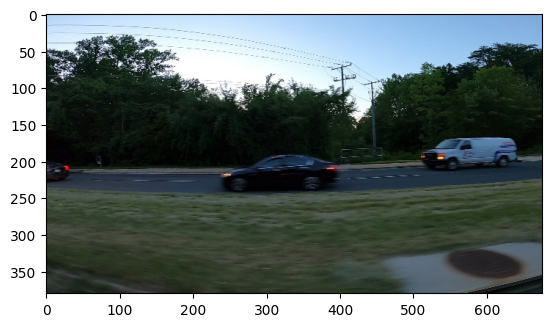

In [ ]:
from PIL import Image

image_path = img
image = Image.open(image_path)

image_array = np.array(image)
image_dtype = image_array.dtype

print("Image data type:", image_dtype)
plt.imshow(image_array)

In [ ]:
results = model.predict(image_array, conf = 0.5)


0: 384x640 1 car, 1 truck, 17.3ms
Speed: 3.2ms preprocess, 17.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


In [ ]:
for result in results:
    boxes = result.boxes
boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([2., 2., 2., 2.], device='cuda:0')
conf: tensor([0.8944, 0.8913, 0.8261, 0.6764], device='cuda:0')
data: tensor([[567.6403, 177.7681, 675.6870, 233.8482,   0.8944,   2.0000],
        [332.9420, 194.2182, 495.1774, 246.9401,   0.8913,   2.0000],
        [505.2619, 181.3756, 601.4539, 223.2661,   0.8261,   2.0000],
        [236.9280, 192.1705, 271.4705, 210.6890,   0.6764,   2.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (380, 676)
shape: torch.Size([4, 6])
xywh: tensor([[621.6636, 205.8082, 108.0467,  56.0801],
        [414.0597, 220.5791, 162.2354,  52.7220],
        [553.3578, 202.3209,  96.1920,  41.8905],
        [254.1992, 201.4297,  34.5425,  18.5185]], device='cuda:0')
xywhn: tensor([[0.9196, 0.5416, 0.1598, 0.1476],
        [0.6125, 0.5805, 0.2400, 0.1387],
        [0.8186, 0.5324, 0.1423, 0.1102],
        [0.3760, 0.5301, 0.0511, 0.0487]], device='cuda:0')
xyxy: tensor([[567.6403, 177.7681, 6

In [ ]:
class_names = model.names

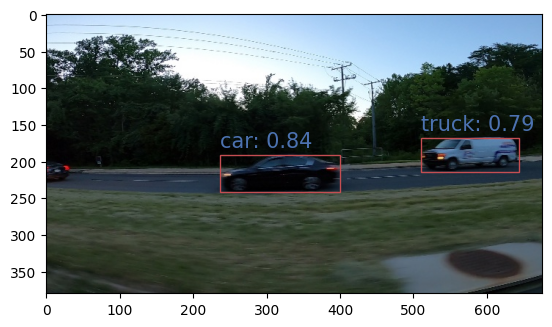

In [ ]:
# Create a figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(image_array)

# Iterate over the boxes and annotations
for box, conf, class_idx in zip(boxes.xyxy.cpu(), boxes.conf.cpu(), boxes.cls.cpu()):
    # Get the class index
    class_index = int(class_idx)

    # Get the class name
    class_name = class_names[class_index]

    # Get the box coordinates
    x1, y1, x2, y2 = box[:4]

    # Create a rectangle patch
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')

    # Add the rectangle patch to the axes
    ax.add_patch(rect)

    # Add the label and confidence score
    label = f"{class_name}: {conf:.2f}"
    ax.text(x1, y1 - 10, label, fontsize=15, color='b')

# Show the plot
plt.show()

### Train & Test

In [ ]:
train_data = '/content/car_data/training_images'
test_data = '/content/car_data/testing_images'
csv_data = '/content/car_data/train_solution_bounding_boxes (1).csv'

In [ ]:
!mkdir -p "/content/car_data/data"
!mkdir -p "/content/car_data/data/images"
!mkdir -p "/content/car_data/data/images/train"
!mkdir -p "/content/car_data/data/images/val"
!mkdir -p "/content/car_data/data/labels"
!mkdir -p "/content/car_data/data/labels/train"
!mkdir -p "/content/car_data/data/labels/val"

In [ ]:
root_dir="/content/car_data/data"
labels_dir="/content/car_data/data/labels"
images_dir="/content/car_data/data/images"

In [ ]:
df=pd.read_csv(csv_data)

width=676
height=380

df["class"]=0
df.rename(columns={'image':'img_name'}, inplace=True)

# minmax scaling
df["x_centre"]=(df["xmin"]+df["xmax"])/2
df["y_centre"]=(df["ymin"]+df["ymax"])/2
df["width"]=(df["xmax"]-df["xmin"])
df["height"]=(df["ymax"]-df["ymin"])

# normalizing bounding box coordinates
df["x_centre"]=df["x_centre"]/width
df["y_centre"]=df["y_centre"]/height
df["width"]=df["width"]/width
df["height"]=df["height"]/height

df_yolo=df[["img_name","class","x_centre","y_centre","width","height"]]
df_yolo.sample(5)

,img_name,class,x_centre,y_centre,width,height
271,vid_4_21640.jpg,0,0.722865,0.532095,0.193922,0.138996
509,vid_4_9280.jpg,0,0.022942,0.537443,0.038602,0.062176
110,vid_4_14400.jpg,0,0.040883,0.551400,0.081766,0.097812
518,vid_4_9420.jpg,0,0.708303,0.518661,0.159505,0.117876
387,vid_4_30020.jpg,0,0.065123,0.552043,0.095514,0.081081


In [ ]:
df_yolo

,img_name,class,x_centre,y_centre,width,height
0,vid_4_1000.jpg,0,0.450434,0.539817,0.068741,0.095238
1,vid_4_10000.jpg,0,0.100217,0.557191,0.155572,0.129987
2,vid_4_10040.jpg,0,0.444645,0.543678,0.181621,0.157014
3,vid_4_10020.jpg,0,0.833213,0.531451,0.197540,0.155727
4,vid_4_10060.jpg,0,0.110347,0.559122,0.171491,0.136422
...,...,...,...,...,...,...
554,vid_4_9860.jpg,0,0.036417,0.571770,0.072833,0.099741
555,vid_4_9880.jpg,0,0.640932,0.535500,0.305899,0.247409
556,vid_4_9900.jpg,0,0.104880,0.536148,0.209760,0.186528
557,vid_4_9960.jpg,0,0.816824,0.527728,0.191551,0.148964


In [ ]:
img_list = list(sorted(os.listdir(train_data)))
np.random.shuffle(img_list)

In [ ]:
for i, img_name in enumerate(img_list):
    subset = "train"
    if i >= 80/100 * len(img_list):
        subset = "val"


    if np.isin(img_name, df_yolo['img_name']):
        columns = ["class", "x_centre", "y_centre", "width", "height"]
        img_box = df[df['img_name'] == img_name][columns].values
        label_path = os.path.join(labels_dir,subset, img_name[:-4] + ".txt")
        with open(label_path, "w+") as f:
            for row in img_box:
                text = " ".join(row.astype(str))
                f.write(text)
                f.write("\n")

    old_image_path = os.path.join(train_data, img_name)
    new_image_path = os.path.join(images_dir, subset, img_name)
    shutil.copy(old_image_path, new_image_path)

In [ ]:
# path to folder
a = "/content/car_data/data/images/train"
b = "/content/car_data/data/labels/train"

# Count the number of files in each directory
num_files_a = len(os.listdir(a))
num_files_b = len(os.listdir(b))

print(f"Number of files in the directory {a}: {num_files_a}")
print(f"Number of files in the directory {b}: {num_files_b}")

Number of files in the directory /content/car_data/data/images/train: 801
Number of files in the directory /content/car_data/data/labels/train: 282


In [ ]:
yolo_format=dict(path="/content/car_data/data",
                 train="/content/car_data/data/images/train",
                 val="/content/car_data/data/images/val",
                 nc=1,
                 names={0:"car"})

with open('/content/car_data/data/yolo.yaml', 'w') as outfile:
    yaml.dump(yolo_format, outfile, default_flow_style=False)

In [ ]:
model.train(data="/content/car_data/data/yolo.yaml",epochs=5,patience=5,batch=8,
                    lr0=0.0005,imgsz=640)

Ultralytics YOLOv8.1.8 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/car_data/data/yolo.yaml, epochs=5, time=None, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show

100%|██████████| 755k/755k [00:00<00:00, 24.7MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

 22        [15, 18, 21]  1   2116435  ultralytics.nn.modules.head.Detect           [1, [128, 256, 512]]          
Model summary: 225 layers, 11135987 parameters, 11135971 gradients, 28.6 GFLOPs

Transferred 64/355 items from pretrained weights
TensorBoard: Start with 'tensorboard --logdir runs/detect/train', view at http://localhost:6006/
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.23M/6.23M [00:00<00:00, 107MB/s]


AMP: checks passed ✅


train: Scanning /content/car_data/data/labels/train... 282 images, 519 backgrounds, 0 corrupt: 100%|██████████| 801/801 [00:00<00:00, 2963.32it/s]

train: New cache created: /content/car_data/data/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/car_data/data/labels/val... 73 images, 127 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<00:00, 2617.76it/s]

val: New cache created: /content/car_data/data/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.23G      1.594      3.634      1.327          8        640: 100%|██████████| 101/101 [00:24<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:04<00:00,  3.11it/s]

                   all        200        133      0.926      0.865      0.941      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.34G      1.331       1.67      1.131          3        640: 100%|██████████| 101/101 [00:19<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  8.27it/s]


                   all        200        133      0.939      0.887      0.951      0.555

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       2.3G      1.355      1.464      1.124          1        640: 100%|██████████| 101/101 [00:24<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.41it/s]

                   all        200        133        0.9      0.917      0.956      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.32G      1.253      1.185      1.069          0        640: 100%|██████████| 101/101 [00:20<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  5.00it/s]

                   all        200        133      0.952      0.902      0.967      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.33G      1.256      1.106      1.091          1        640: 100%|██████████| 101/101 [00:19<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.99it/s]

                   all        200        133      0.912      0.947      0.958      0.592



5 epochs completed in 0.035 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.8 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.25it/s]


                   all        200        133      0.952      0.902      0.967       0.61
Speed: 0.4ms preprocess, 5.4ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7eb003e49090>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
path_best_weights="/content/runs/detect/train/weights/best.pt"
model = YOLO(path_best_weights)
metrics = model.val()

Ultralytics YOLOv8.1.8 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/car_data/data/labels/val.cache... 73 images, 127 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.70it/s]


                   all        200        133      0.952      0.901      0.967       0.61
Speed: 0.2ms preprocess, 8.3ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/detect/val


In [ ]:
print(f"Mean Average Precision @.5:.95 : {metrics.box.map}")     # the average AP for IoU from 0.5 to 0.95 with a step size of 0.05
print(f"Mean Average Precision @ .50   : {metrics.box.map50}")    # AP with IoU=0.50
print(f"Mean Average Precision @ .70   : {metrics.box.map75}")    # AP with IoU=0.70

Mean Average Precision @.5:.95 : 0.6099393276800619
Mean Average Precision @ .50   : 0.9673698945653941
Mean Average Precision @ .70   : 0.7617377498361382


In [ ]:
with torch.no_grad():
    results=model.predict(source=test_data,conf=0.50,iou=0.75)


image 1/175 /content/car_data/testing_images/vid_5_25100.jpg: 384x640 (no detections), 138.0ms
image 2/175 /content/car_data/testing_images/vid_5_25120.jpg: 384x640 (no detections), 17.0ms
image 3/175 /content/car_data/testing_images/vid_5_25140.jpg: 384x640 (no detections), 13.4ms
image 4/175 /content/car_data/testing_images/vid_5_25160.jpg: 384x640 (no detections), 15.5ms
image 5/175 /content/car_data/testing_images/vid_5_25180.jpg: 384x640 (no detections), 14.5ms
image 6/175 /content/car_data/testing_images/vid_5_25200.jpg: 384x640 (no detections), 16.6ms
image 7/175 /content/car_data/testing_images/vid_5_25220.jpg: 384x640 (no detections), 13.0ms
image 8/175 /content/car_data/testing_images/vid_5_25240.jpg: 384x640 (no detections), 23.6ms
image 9/175 /content/car_data/testing_images/vid_5_25260.jpg: 384x640 (no detections), 18.7ms
image 10/175 /content/car_data/testing_images/vid_5_26320.jpg: 384x640 (no detections), 16.0ms
image 11/175 /content/car_data/testing_images/vid_5_26400

In [ ]:
prediction_dir="/content/predictions"

In [ ]:
test_img_list=[]
for result in results:
    if len(result.boxes.xyxy):
        name=result.path.split("/")[-1].split(".")[0]
        boxes=result.boxes.xyxy.cpu().numpy()
        scores=result.boxes.conf.cpu().numpy()

        test_img_list.append(name)

        label_file_path=os.path.join(prediction_dir,name+".txt")
        with open(label_file_path,"w+") as f:
            for score,box in zip(scores,boxes):
                text=f"{score:0.4f} "+" ".join(box.astype(str))
                f.write(text)
                f.write("\n")

In [ ]:
def show_bbox(img,boxes,scores,axis,color=(0,255,0)):
    boxes=boxes.astype(int)
    scores=scores
    img=img.copy()
    for i,box in enumerate(boxes):
        score=f"{scores[i]:.4f}"
        cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),color,2)
        y=box[1]-10 if box[1]-10>10 else box[1]+10
        cv2.putText(img,score,(box[0],y),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)

    axis.imshow(img)
    axis.axis("off")

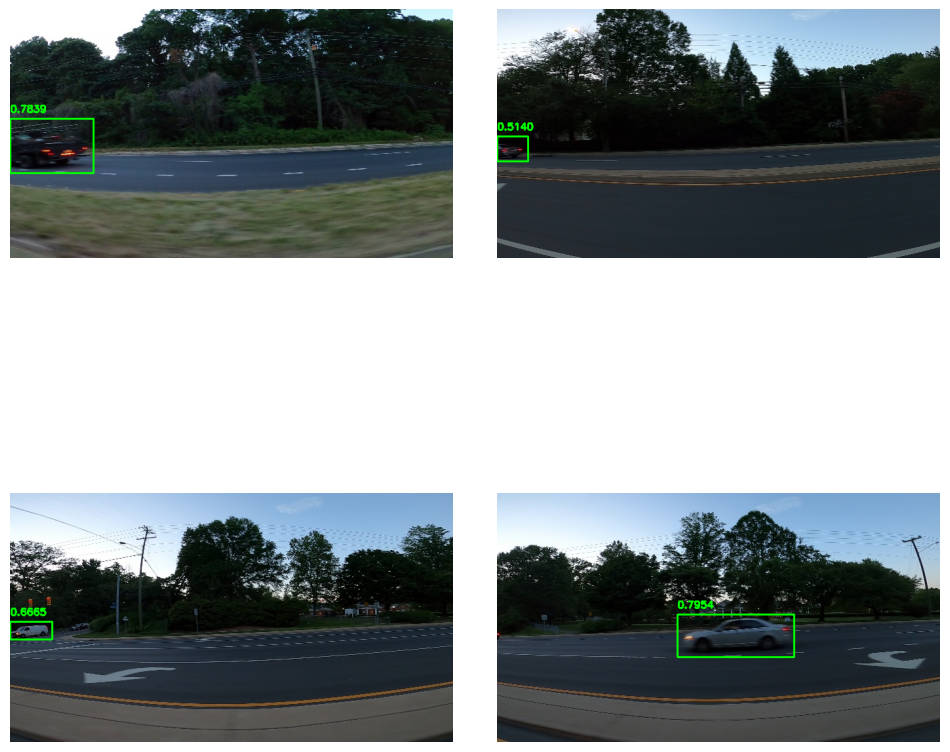

In [ ]:
fig,axes=plt.subplots(2,2,figsize=(12,12))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
ax=axes.flatten()

imgs_name=np.random.choice(test_img_list,4)

for i,img_name in enumerate(imgs_name):
    img_file_path=os.path.join(test_data,img_name+".jpg")
    img=cv2.imread(img_file_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    label_file_path=os.path.join(prediction_dir,img_name+".txt")
    label=pd.read_csv(label_file_path,sep=" ",header=None).values
    scores=label[:,0]
    boxes=label[:,1:]
    show_bbox(img,boxes,scores,axis=ax[i])

plt.savefig("car.png")